In [1]:
import os
import sys
file_path = os.path.abspath('./utils')
print(file_path)
sys.path.append(file_path)
import CommonUtil as cu    # ct_win


/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/1_source/utils


In [2]:
import glob
import h5py
import cv2
import numpy as np

from tqdm import tqdm, tqdm_notebook
import shutil
import json
import SimpleITK as sitk
import matplotlib.pylab as plt
from skimage.transform import resize
from datetime import datetime, timedelta, timezone
import nibabel as nib
import SimpleITK as sitk
import pydicom

In [3]:
win_level = 50
win_width = 300
#os.makedirs(save_dir)

In [4]:
width = 128
height = 128
channel = 1


In [5]:
ct__dir = os.path.abspath('../0_data/data_origin/2/volume')
lab_dir = os.path.abspath('../0_data/data_origin/2/segmentation')

save_dir = os.path.abspath('../0_data/data_preprocessing')
os.makedirs(save_dir, exist_ok=True)

print(ct__dir)
print(lab_dir)
print(save_dir)


/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/0_data/data_origin/2/volume
/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/0_data/data_origin/2/segmentation
/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/0_data/data_preprocessing


# data path 가져오기

In [6]:
ct__list = sorted(glob.glob(f'{ct__dir}/*.nii'))
lab_list = [path.replace('volume', 'segmentation') for path in ct__list]

print(len(ct__list), ct__list[0])
print(len(lab_list), lab_list[0])


131 /home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/0_data/data_origin/2/volume/volume-0.nii
131 /home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/0_data/data_origin/2/segmentation/segmentation-0.nii


In [7]:
for i in range(len(ct__list)):
    check__ct = os.path.isfile(ct__list[i])
    check_lab = os.path.isfile(lab_list[i])
    if check__ct and check_lab:
        continue
    else:
        print(check__ct, ct__list[i])
        print(check_lab, lab_list[i])
    

In [8]:
ct__data = []
lab_data = []
for a in tqdm_notebook(range(len(ct__list))):
    ct_ = sitk.ReadImage(ct__list[a])
    lab = sitk.ReadImage(lab_list[a])
    # 파일을 이미지타입의 이미지로 읽는다.

    ct__array = sitk.GetArrayFromImage(ct_)
    lab_array = sitk.GetArrayFromImage(lab)   
    # 이미지타입의 이미지를 배열타입의 이미지로 읽는다.
    
    ct__array = cu.win_scale(ct__array, win_level, win_width, np.uint8, (0, 255))
    
    print(ct__array.shape, np.min(ct__array), np.max(ct__array))
    print(lab_array.shape, np.min(lab_array), np.max(lab_array))
    
    ct__data.append(ct__array)
    lab_data.append(lab_array)

# ct__data = np.array(ct__data)
# lab_data = np.array(lab_data)

# print(ct__data.shape, np.min(ct__data), np.max(ct__data))
# print(lab_data.shape, np.min(lab_data), np.max(lab_data))


/tmp/ipykernel_1670335/680246474.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for a in tqdm_notebook(range(len(ct__list))):


  0%|          | 0/131 [00:00<?, ?it/s]

(75, 512, 512) 0 255
(75, 512, 512) 0 2
(123, 512, 512) 0 255
(123, 512, 512) 0 2
(501, 512, 512) 0 255
(501, 512, 512) 0 2
(685, 512, 512) 0 255
(685, 512, 512) 0 2
(683, 512, 512) 0 255
(683, 512, 512) 0 2
(677, 512, 512) 0 255
(677, 512, 512) 0 2
(683, 512, 512) 0 255
(683, 512, 512) 0 2
(781, 512, 512) 0 255
(781, 512, 512) 0 2
(986, 512, 512) 0 255
(986, 512, 512) 0 1
(771, 512, 512) 0 255
(771, 512, 512) 0 1
(771, 512, 512) 0 255
(771, 512, 512) 0 2
(856, 512, 512) 0 255
(856, 512, 512) 0 2
(756, 512, 512) 0 255
(756, 512, 512) 0 2
(466, 512, 512) 0 255
(466, 512, 512) 0 2
(816, 512, 512) 0 255
(816, 512, 512) 0 2
(761, 512, 512) 0 255
(761, 512, 512) 0 2
(751, 512, 512) 0 255
(751, 512, 512) 0 2
(836, 512, 512) 0 255
(836, 512, 512) 0 2
(846, 512, 512) 0 255
(846, 512, 512) 0 1
(846, 512, 512) 0 255
(846, 512, 512) 0 1
(908, 512, 512) 0 255
(908, 512, 512) 0 2
(836, 512, 512) 0 255
(836, 512, 512) 0 2
(427, 512, 512) 0 255
(427, 512, 512) 0 2
(461, 512, 512) 0 255
(461, 512, 512

# Preprocessing

In [9]:
def return_liver_section(img_arr, lab_arr):
    ls_img_arr = []
    ls_lab_arr = []
    for i in range(len(img_arr)):
        img_data = img_arr[i]
        lab_data = lab_arr[i]
        
        if img_data.shape != lab_data.shape:
            print('error')
            continue
        
        ls_img_data = []
        ls_lab_data = []
        for j in range(len(img_data)):
            img = img_data[j]
            lab = lab_data[j]
            
            if np.sum(lab) > 0:
                ls_img_data.append(img)
                ls_lab_data.append(lab)
                
        ls_img_data = np.array(ls_img_data)
        ls_lab_data = np.array(ls_lab_data)
        print(img_data.shape, ls_img_data.shape)
        
        ls_img_arr.append(ls_img_data)
        ls_lab_arr.append(ls_lab_data)
    
    return ls_img_arr, ls_lab_arr

In [10]:
ls_ct__data, ls_lab_data = return_liver_section(ct__data, lab_data)


(75, 512, 512) (29, 512, 512)
(123, 512, 512) (29, 512, 512)
(501, 512, 512) (181, 512, 512)
(685, 512, 512) (276, 512, 512)
(683, 512, 512) (259, 512, 512)
(677, 512, 512) (266, 512, 512)
(683, 512, 512) (214, 512, 512)
(781, 512, 512) (194, 512, 512)
(986, 512, 512) (239, 512, 512)
(771, 512, 512) (168, 512, 512)
(771, 512, 512) (248, 512, 512)
(856, 512, 512) (205, 512, 512)
(756, 512, 512) (194, 512, 512)
(466, 512, 512) (167, 512, 512)
(816, 512, 512) (189, 512, 512)
(761, 512, 512) (233, 512, 512)
(751, 512, 512) (191, 512, 512)
(836, 512, 512) (170, 512, 512)
(846, 512, 512) (215, 512, 512)
(846, 512, 512) (186, 512, 512)
(908, 512, 512) (219, 512, 512)
(836, 512, 512) (260, 512, 512)
(427, 512, 512) (122, 512, 512)
(461, 512, 512) (132, 512, 512)
(455, 512, 512) (189, 512, 512)
(424, 512, 512) (120, 512, 512)
(463, 512, 512) (113, 512, 512)
(422, 512, 512) (118, 512, 512)
(432, 512, 512) (115, 512, 512)
(407, 512, 512) (112, 512, 512)
(410, 512, 512) (112, 512, 512)
(401, 512, 

In [11]:
# shape 

def returnArray(img_data, lab_data):
    total_img_data = np.zeros((len(img_data), height, width, channel))
    total_lab_data = np.zeros((len(lab_data), height, width, 2))
    
    for i in tqdm_notebook(range(len(img_data))):
        img_arr = img_data[i]
        lab_arr = lab_data[i]
        
        mid_idx = int(len(img_arr) / 2)
            
        img = img_arr[mid_idx]
        lab = lab_arr[mid_idx]

        liver = np.where(lab > 0, 255, 0)
        cancer = np.where(lab == 2, 255, 0)
        
        img = img.astype(np.uint8)
        liver = liver.astype(np.uint8)
        cancer = cancer.astype(np.uint8)
        
        img = cv2.resize(img, (height, width))
        liver = cv2.resize(liver, (height, width))
        cancer = cv2.resize(cancer, (height, width))
        
        total_img_data[i,:,:,0] = img
        total_lab_data[i,:,:,0] = liver
        total_lab_data[i,:,:,1] = cancer
    total_img_data = np.array(total_img_data)
    total_lab_data = np.array(total_lab_data)
    
    print(total_img_data.shape, np.min(total_img_data), np.max(total_img_data), total_img_data.dtype)
    print(total_lab_data.shape, np.min(total_lab_data), np.max(total_lab_data), total_lab_data.dtype)
    
    return total_img_data, total_lab_data

In [12]:
re_ct__data, re_lab_data = returnArray(ls_ct__data, ls_lab_data)



/tmp/ipykernel_1670335/3400189781.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(img_data))):


  0%|          | 0/131 [00:00<?, ?it/s]

(131, 128, 128, 1) 0.0 255.0 float64
(131, 128, 128, 2) 0.0 255.0 float64


# test

/tmp/ipykernel_1670335/4181653149.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 12))


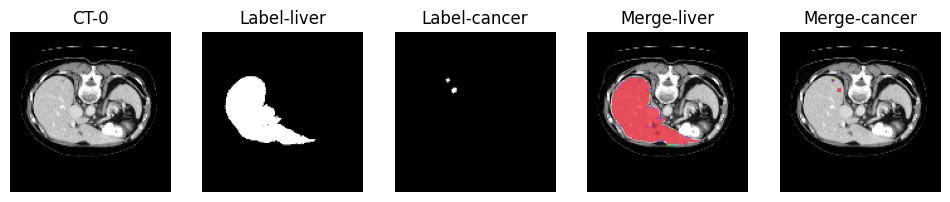

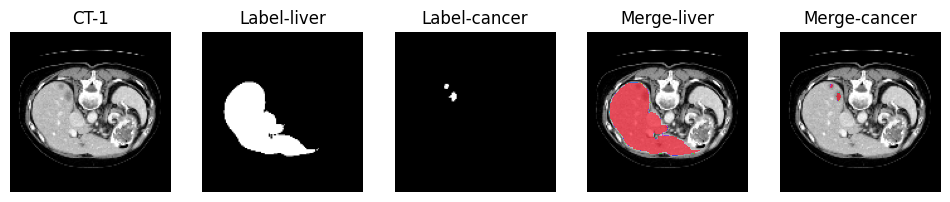

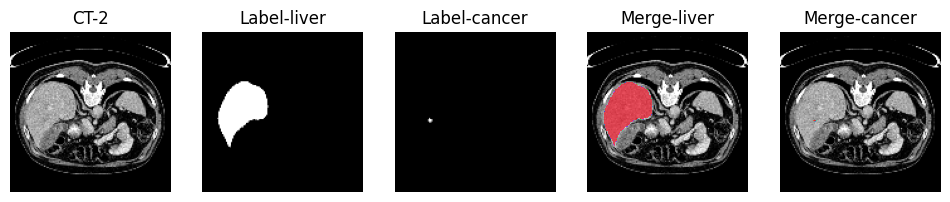

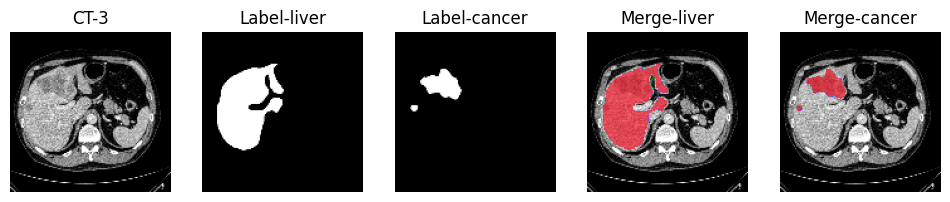

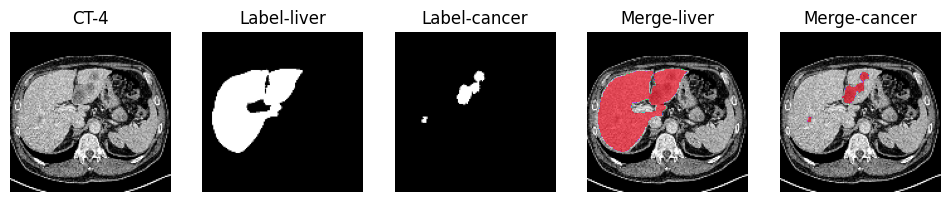

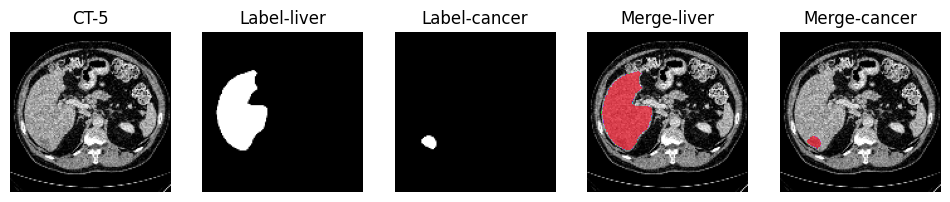

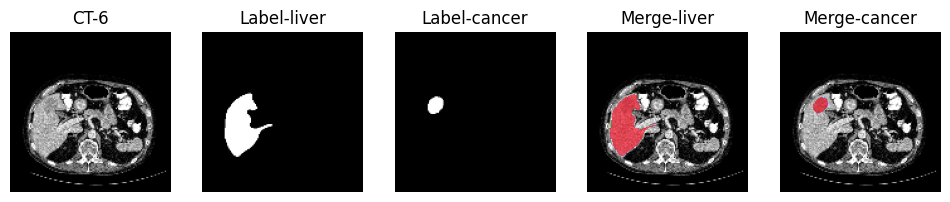

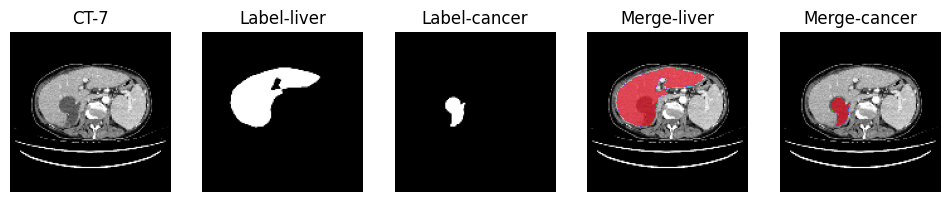

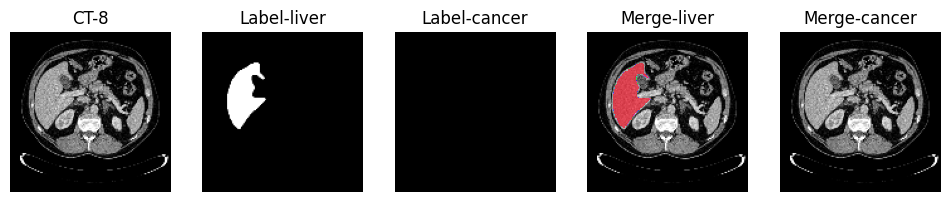

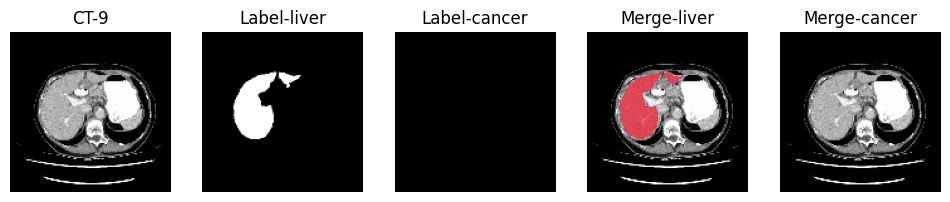

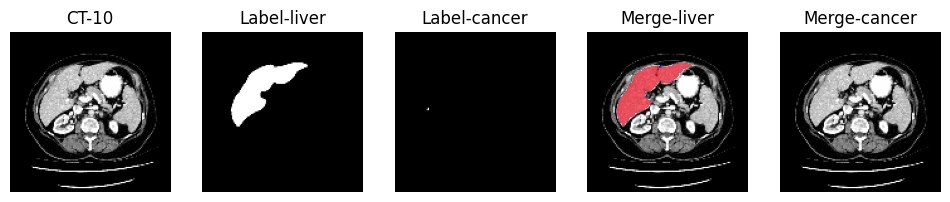

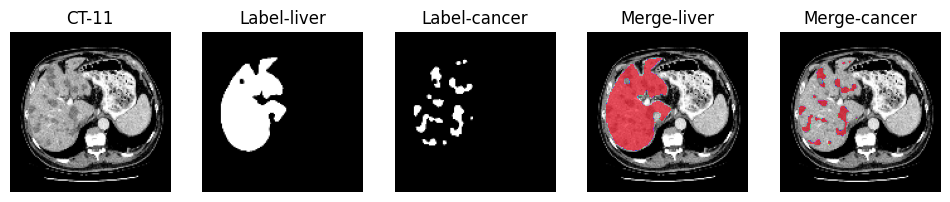

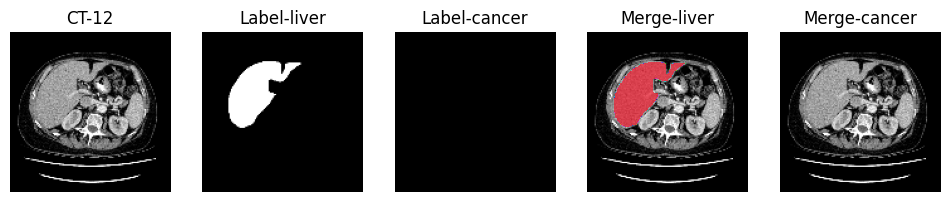

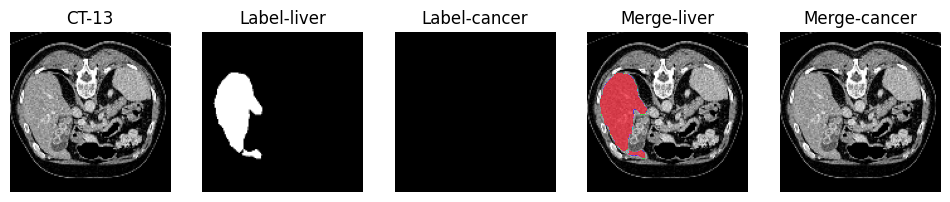

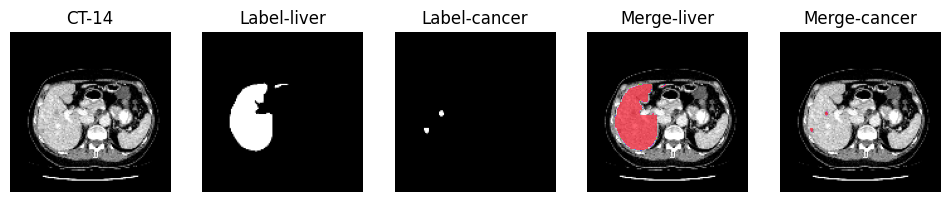

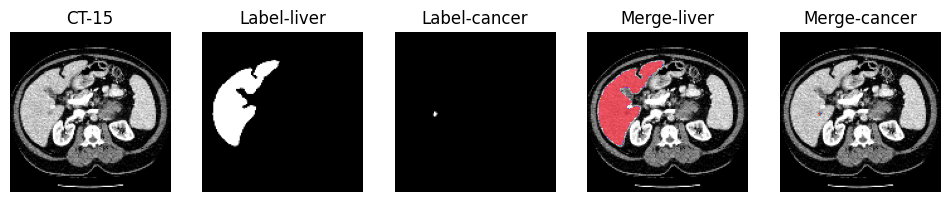

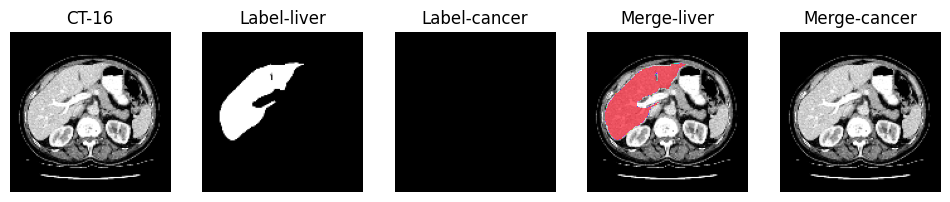

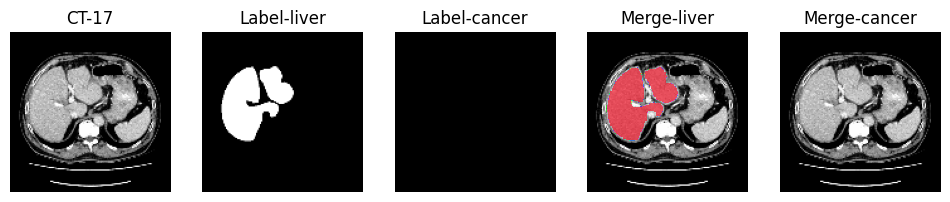

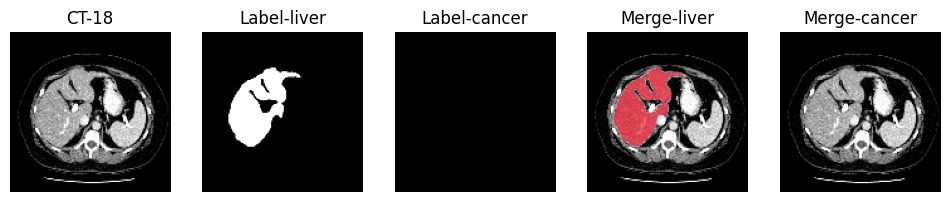

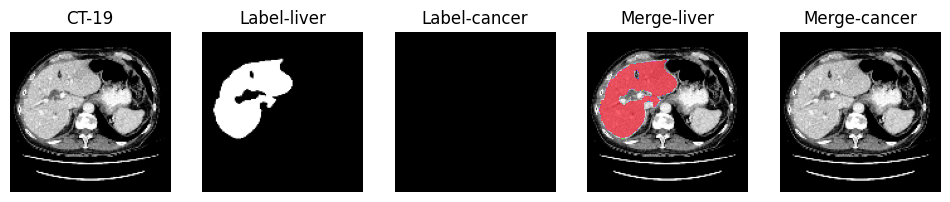

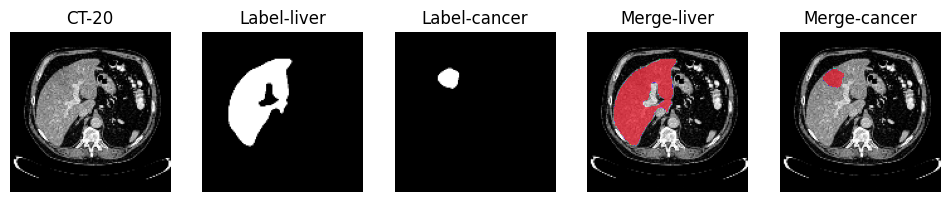

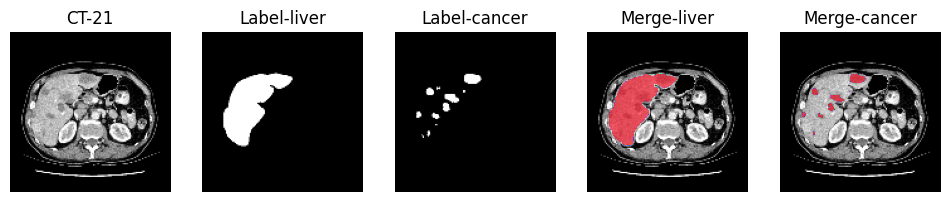

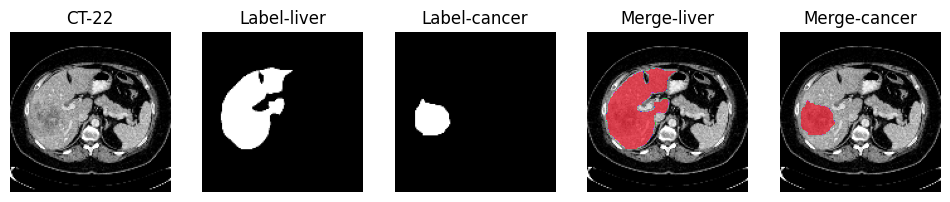

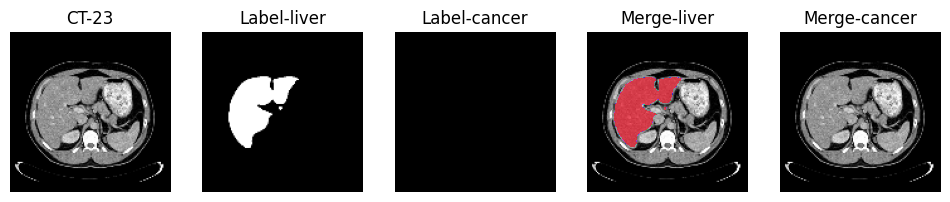

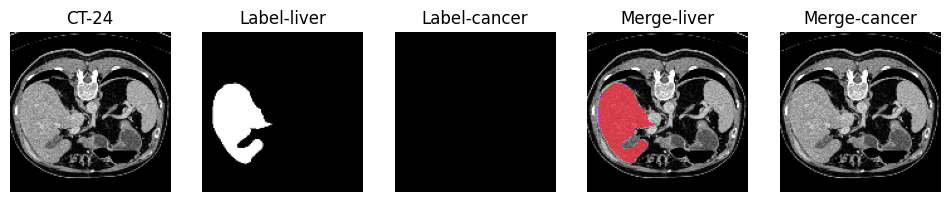

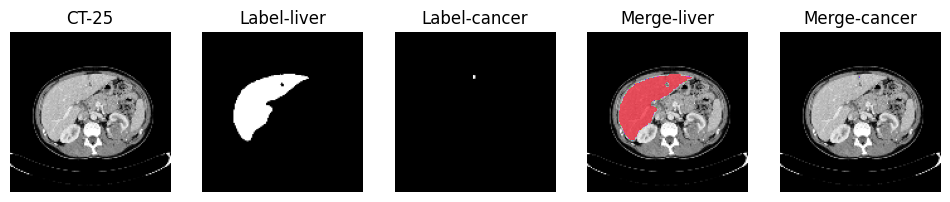

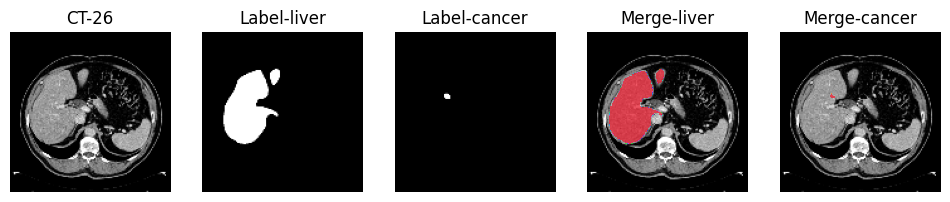

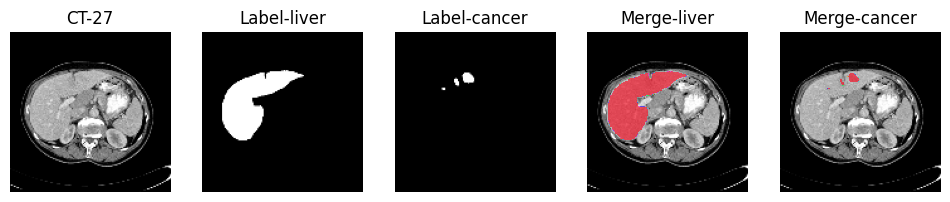

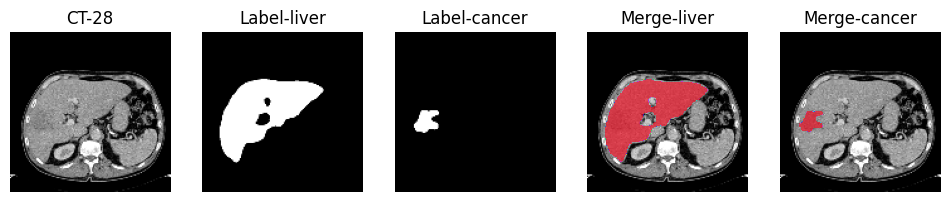

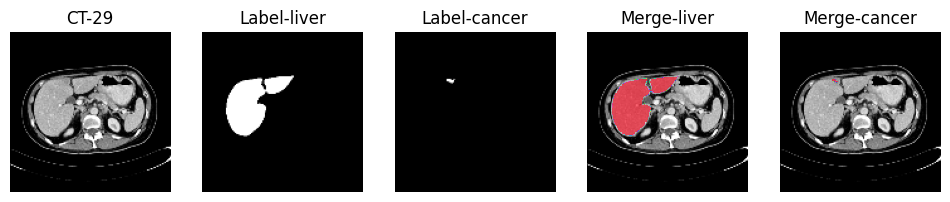

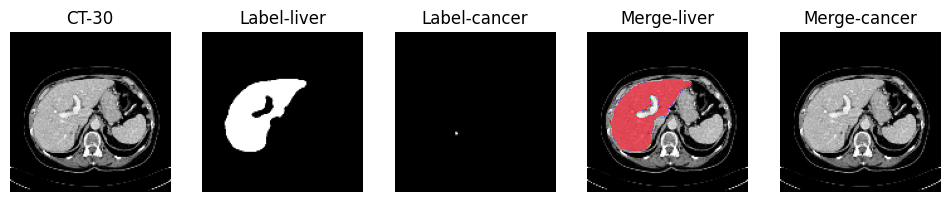

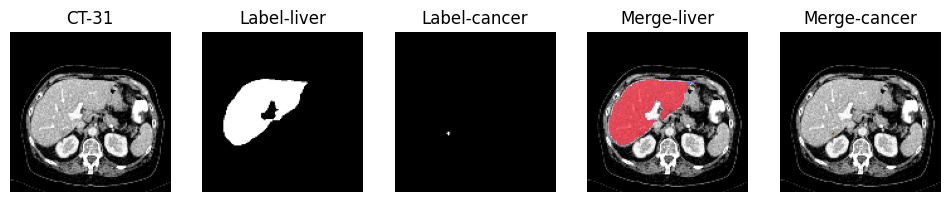

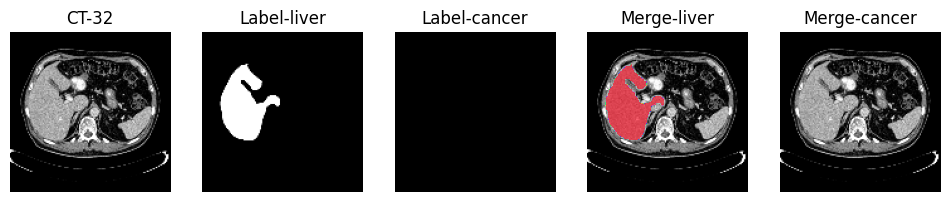

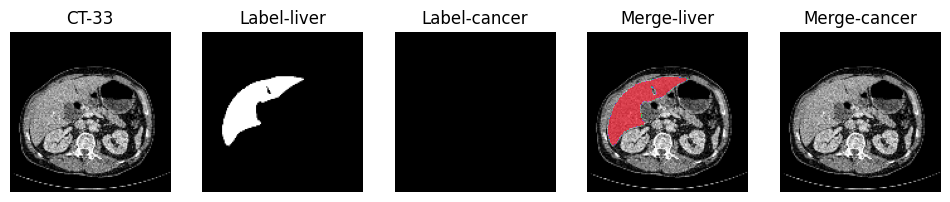

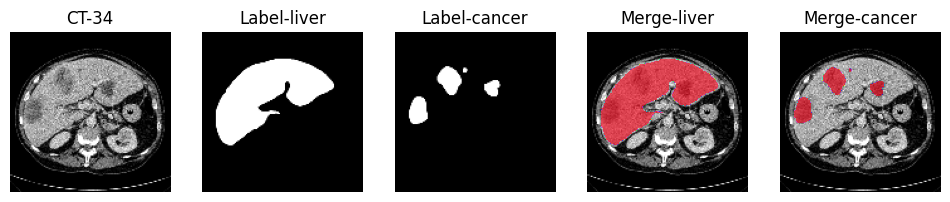

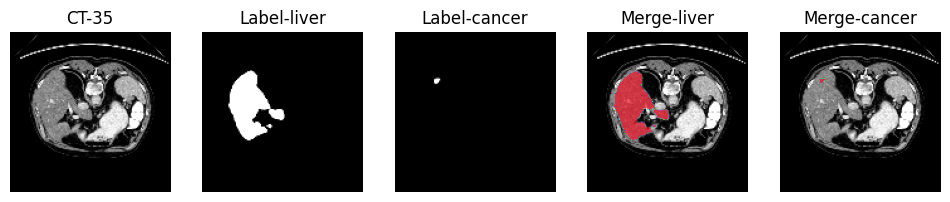

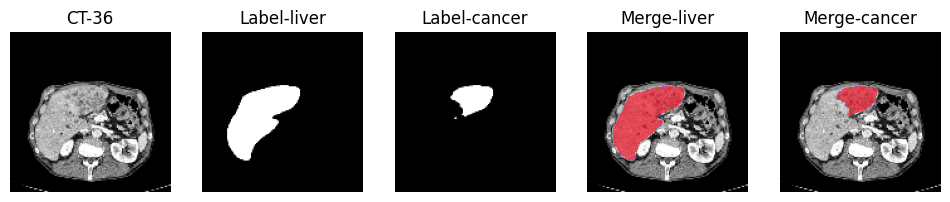

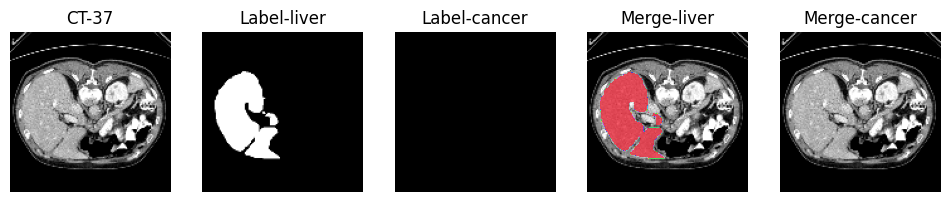

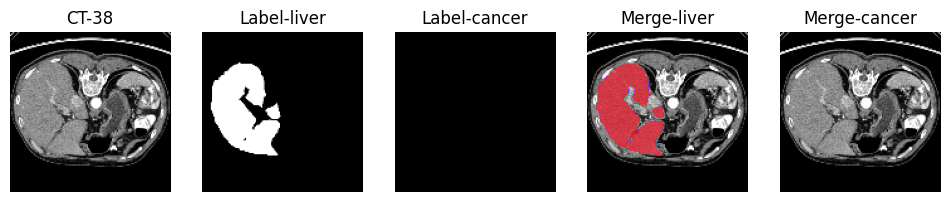

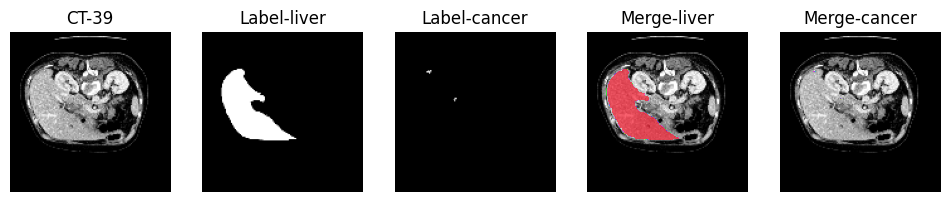

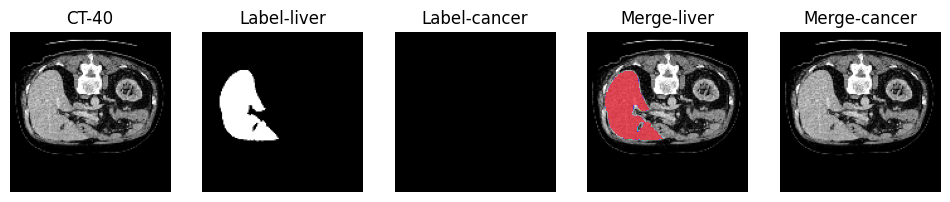

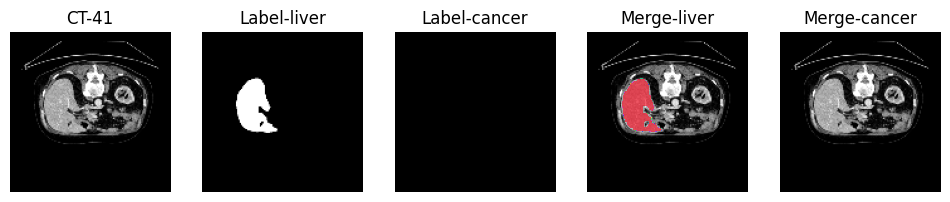

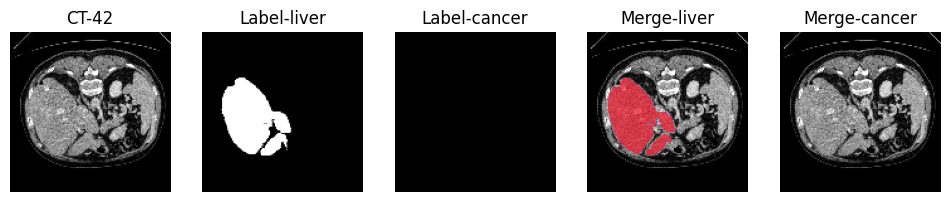

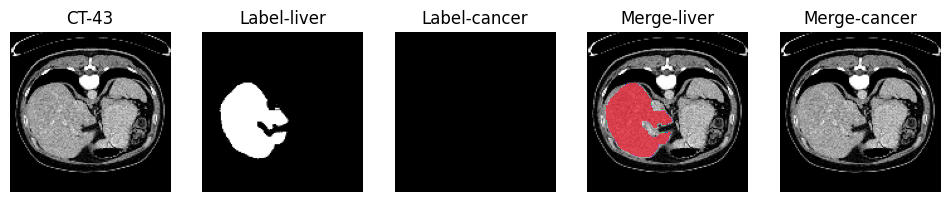

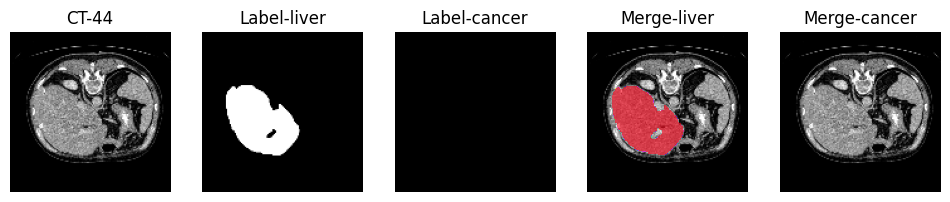

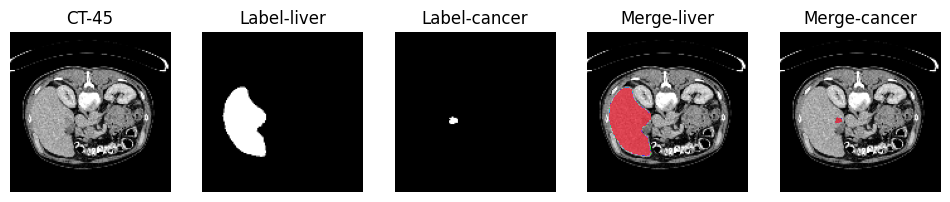

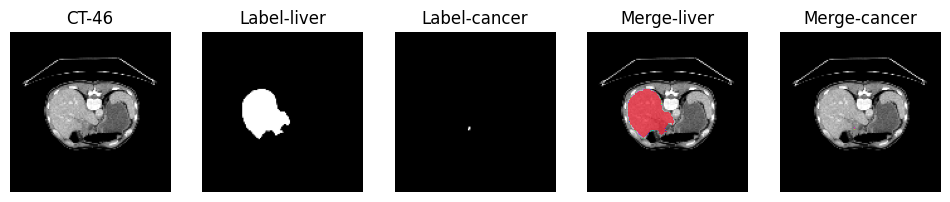

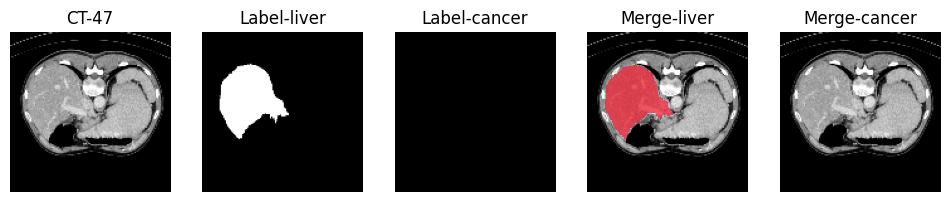

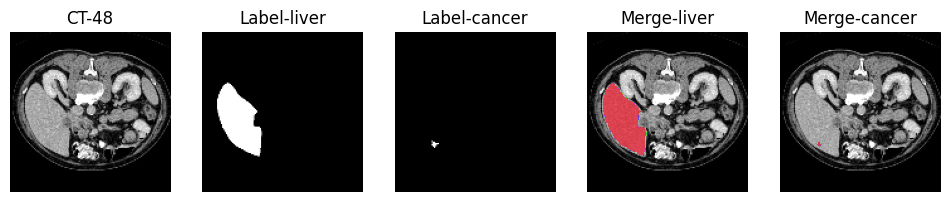

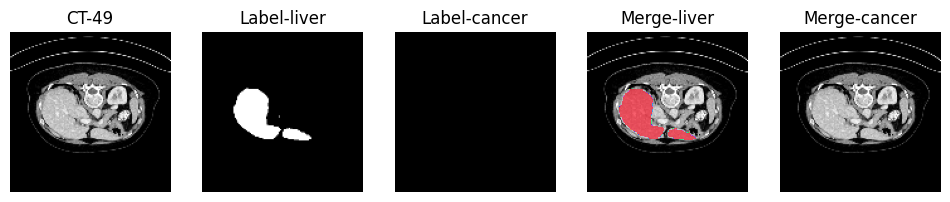

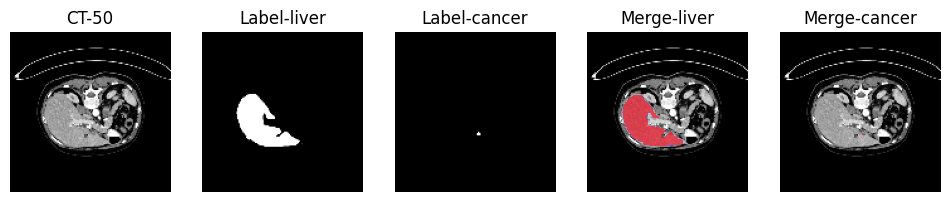

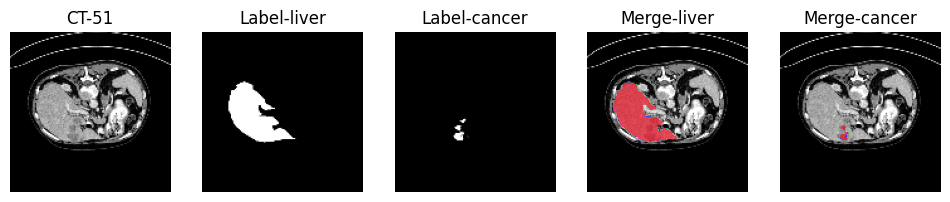

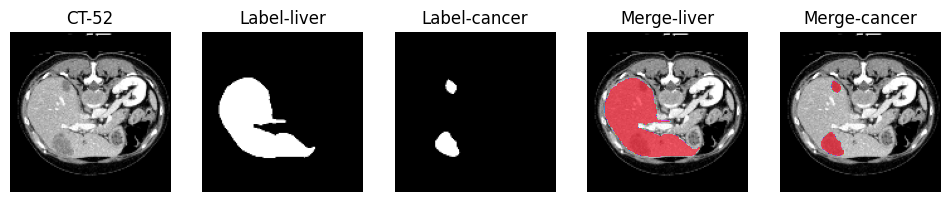

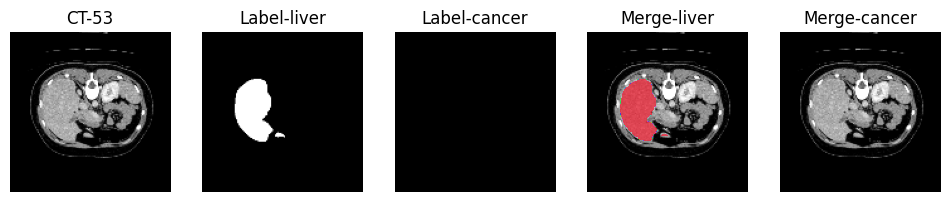

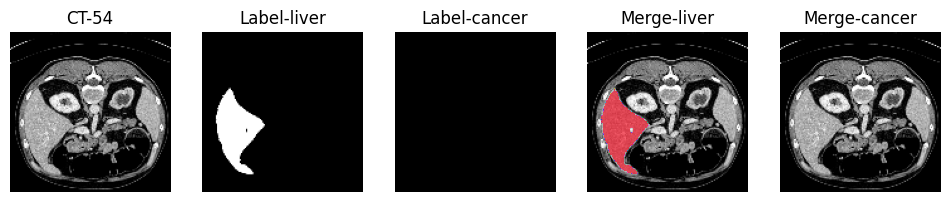

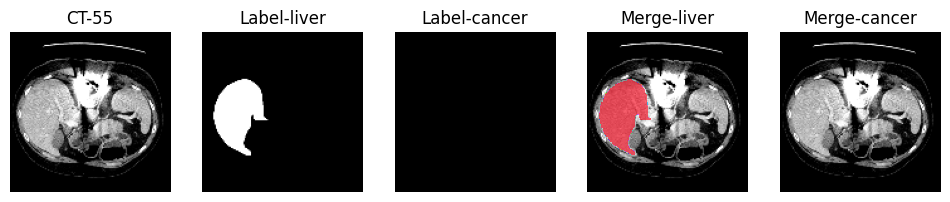

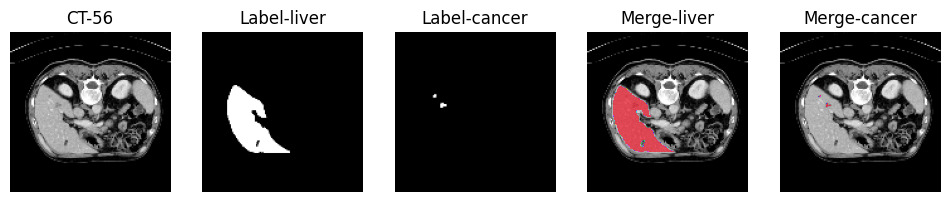

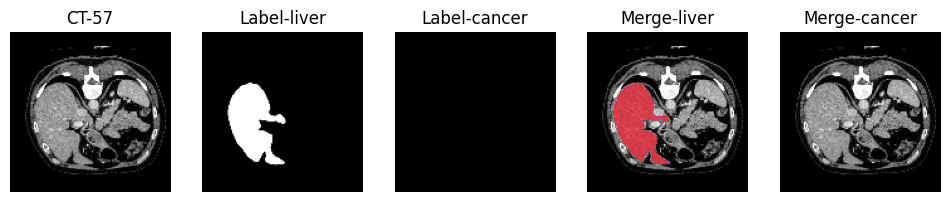

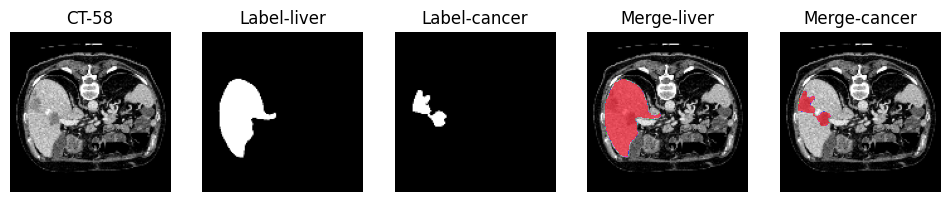

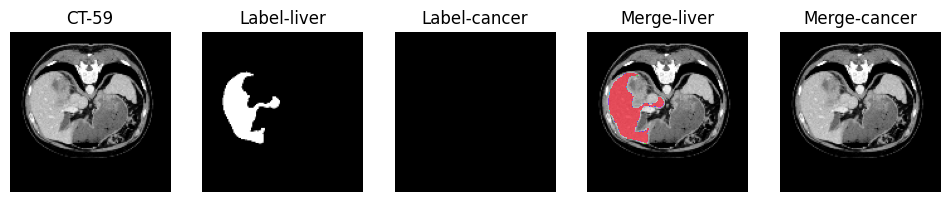

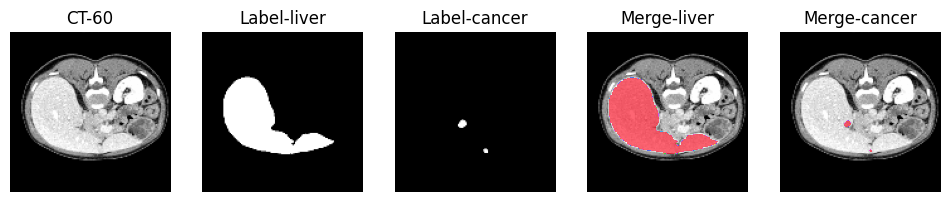

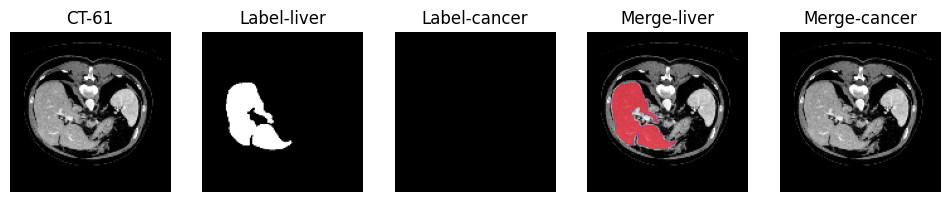

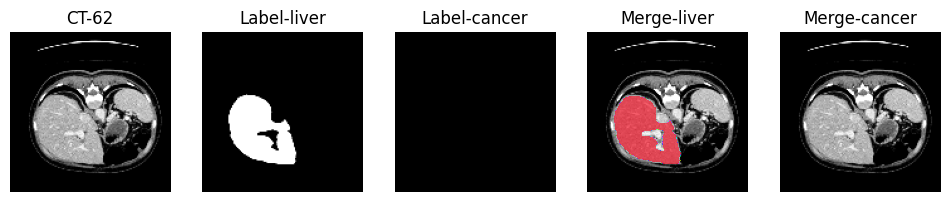

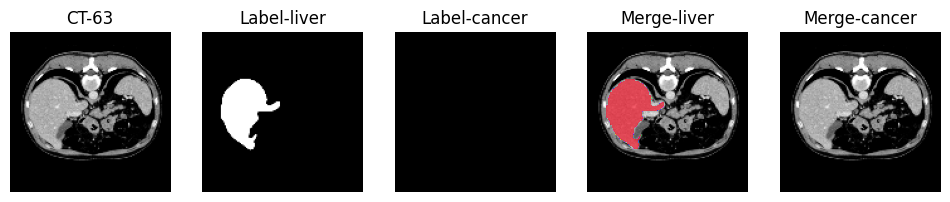

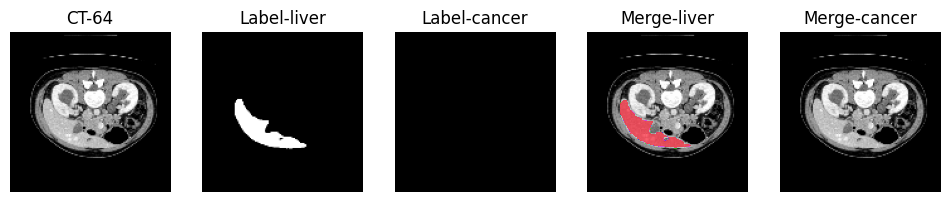

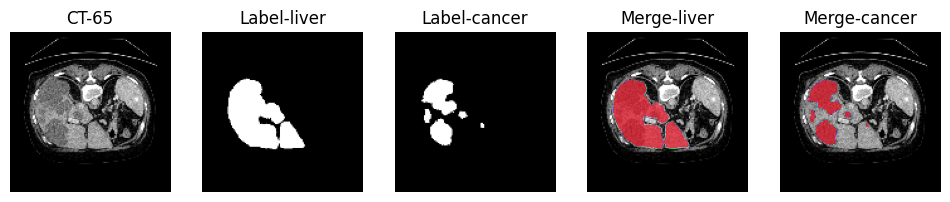

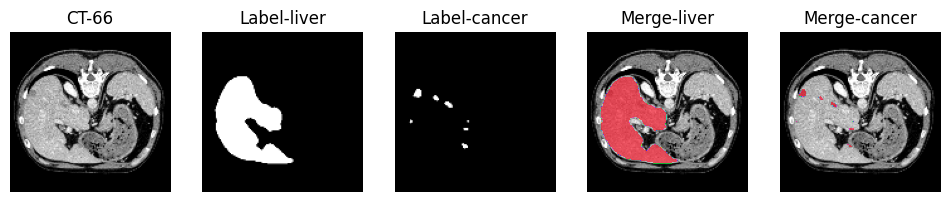

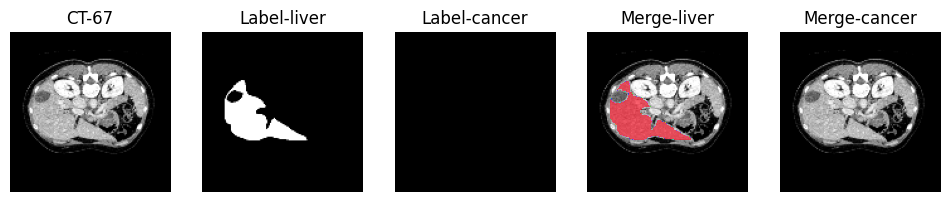

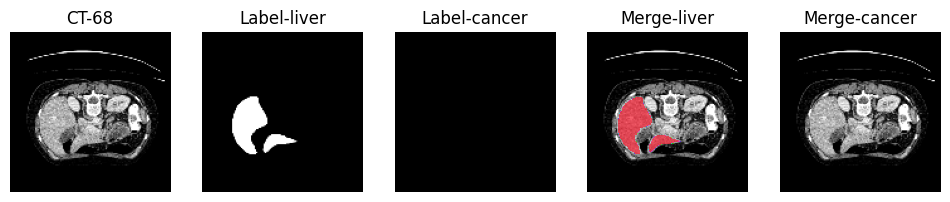

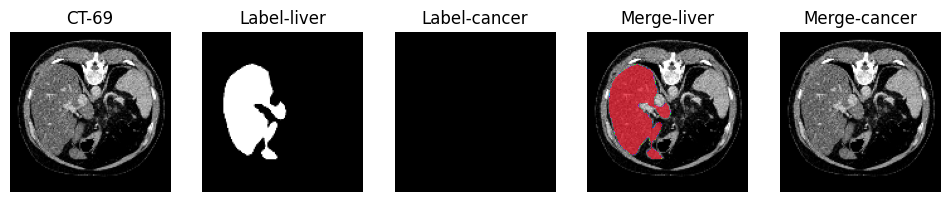

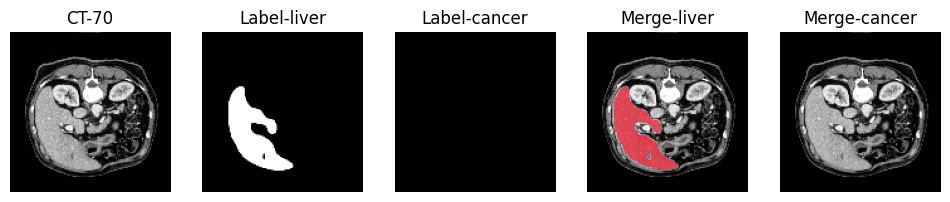

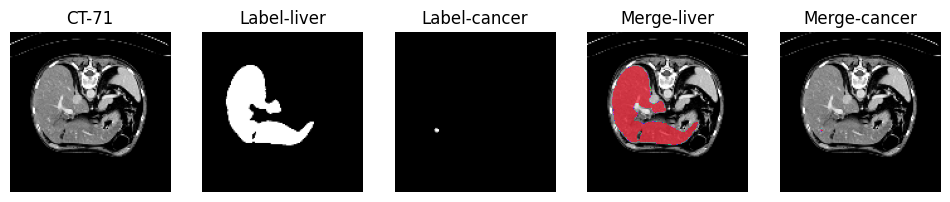

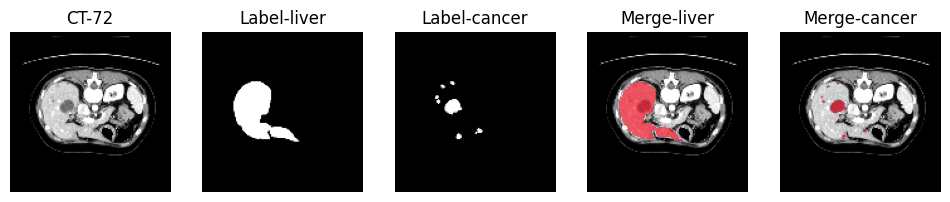

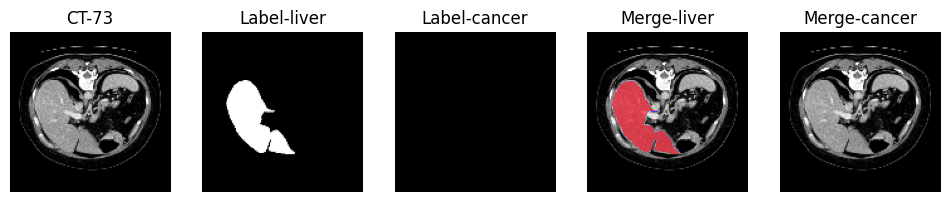

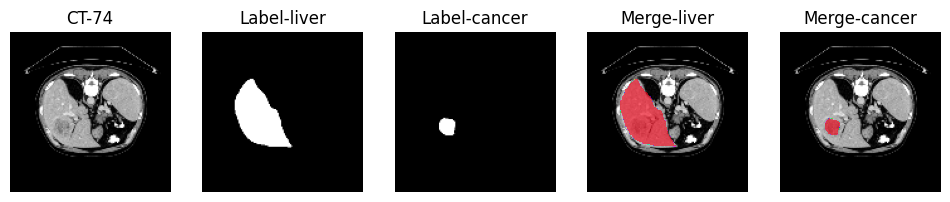

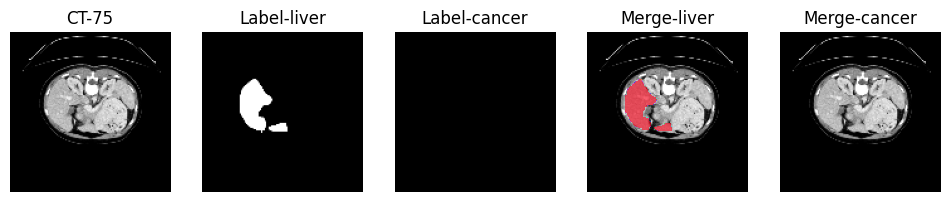

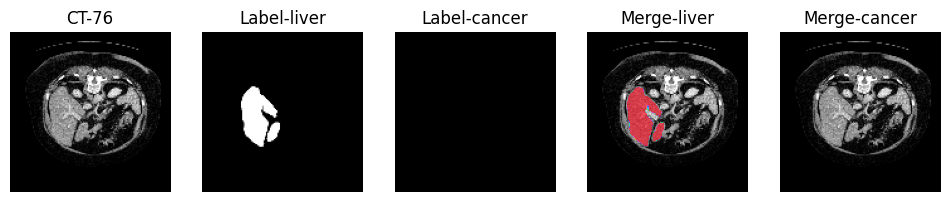

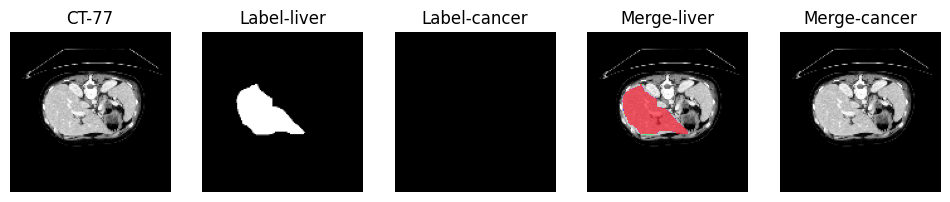

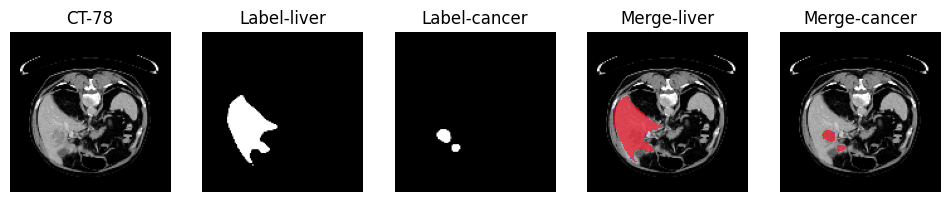

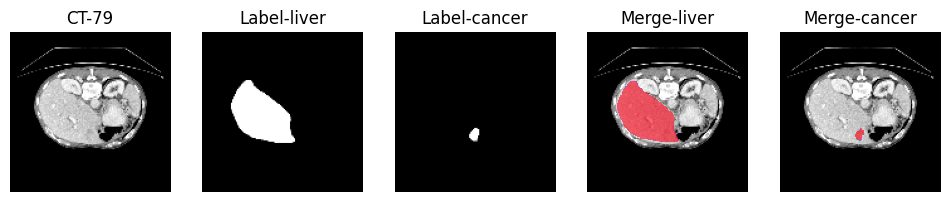

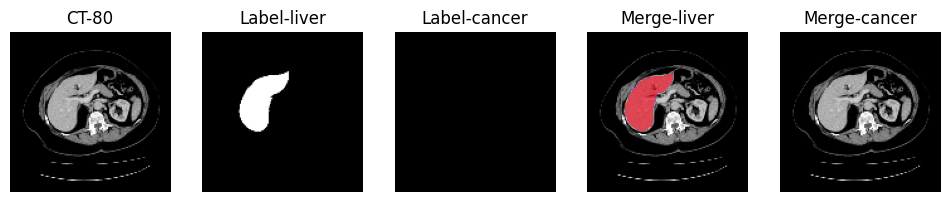

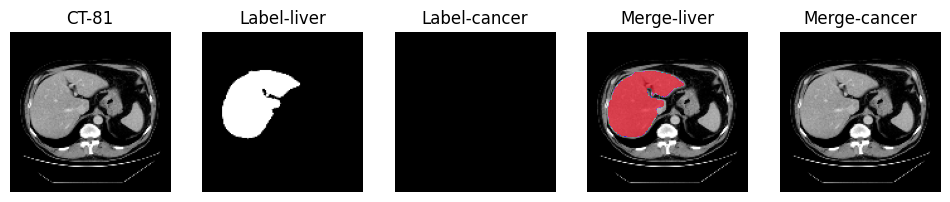

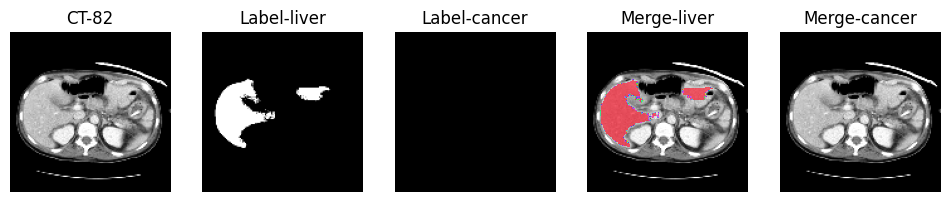

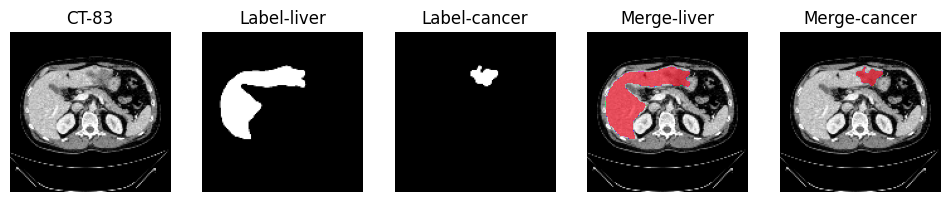

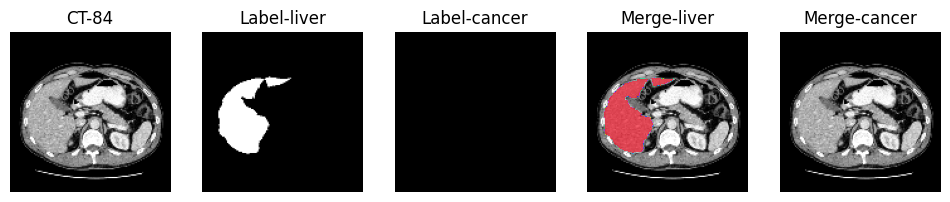

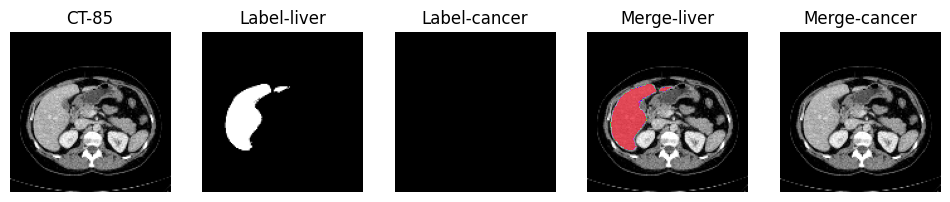

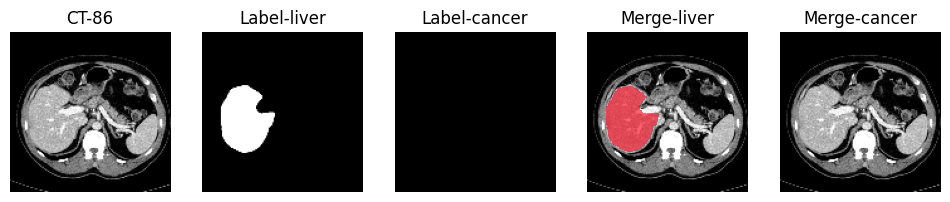

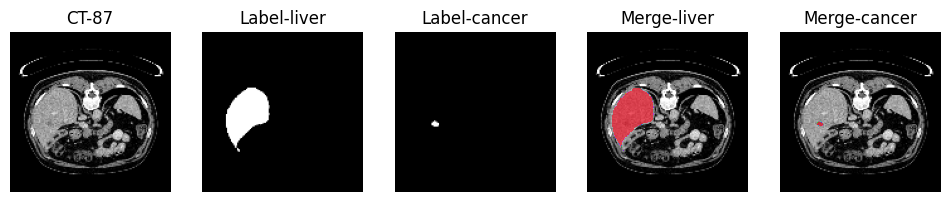

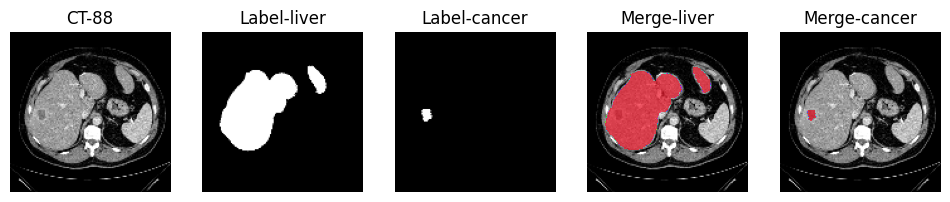

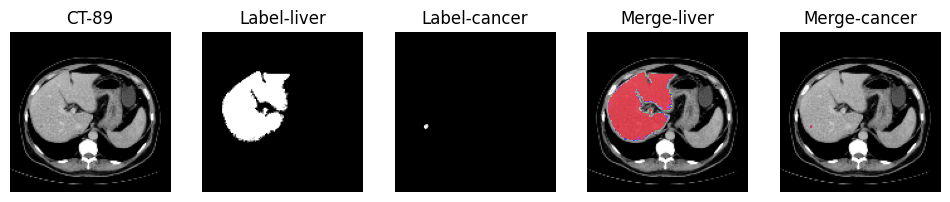

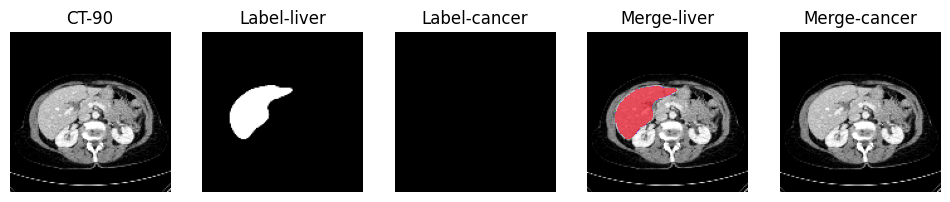

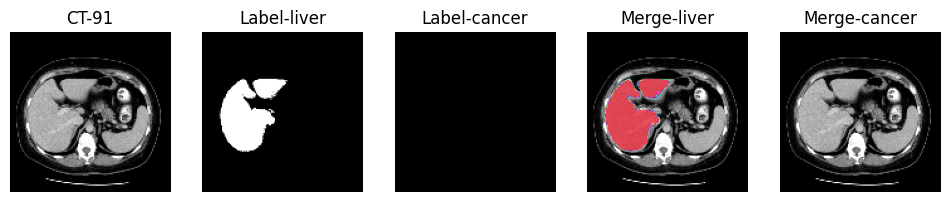

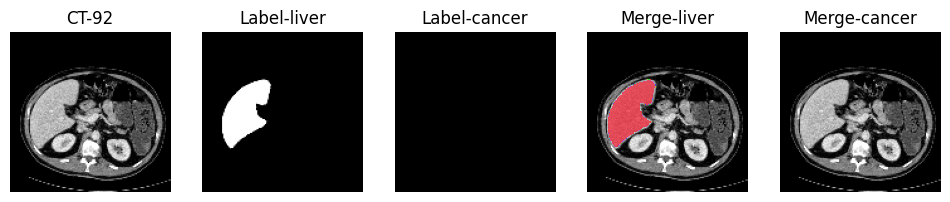

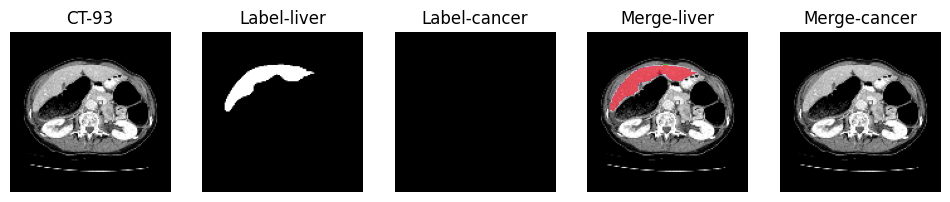

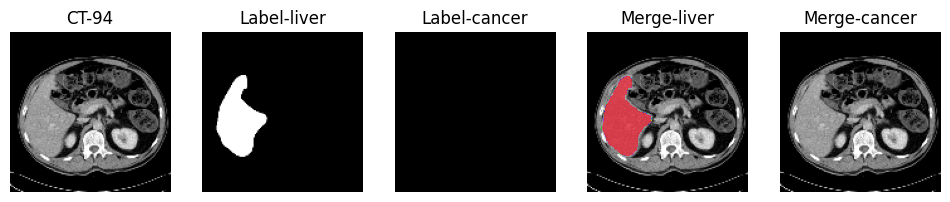

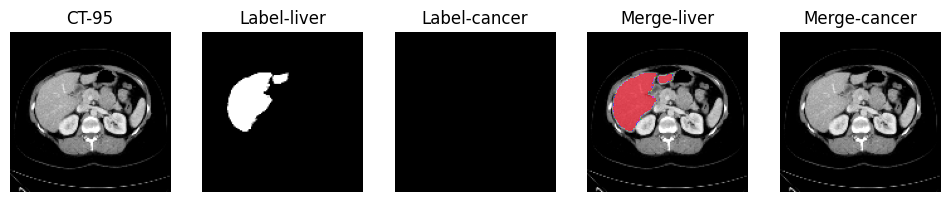

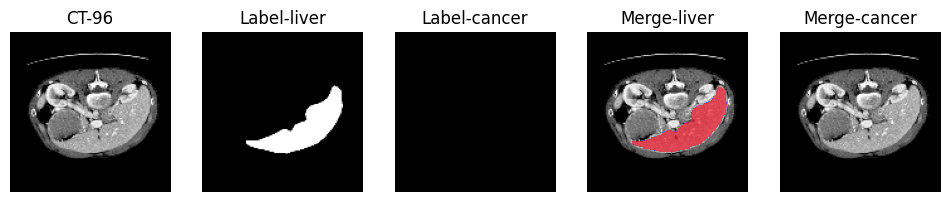

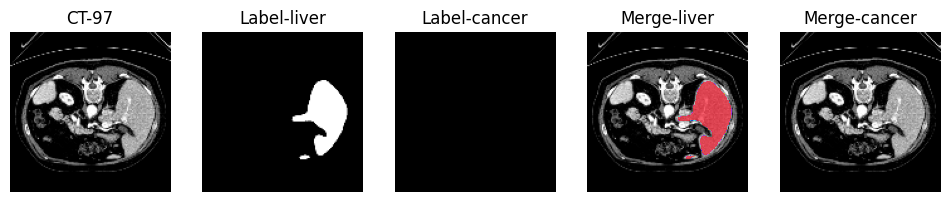

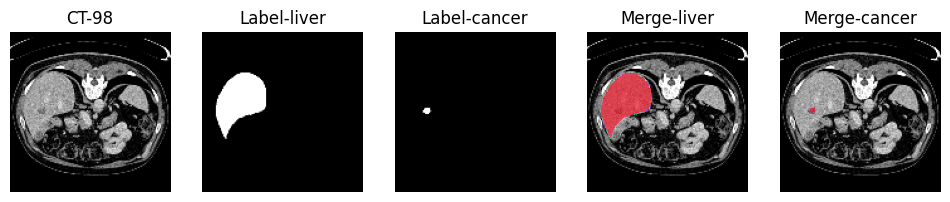

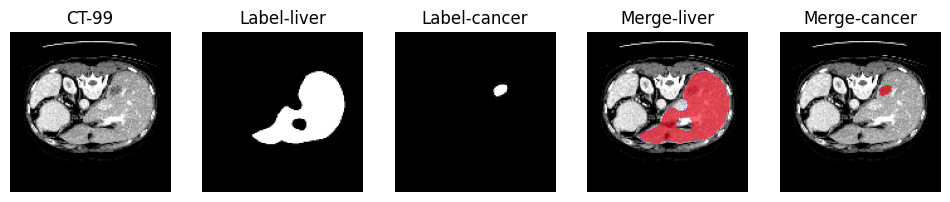

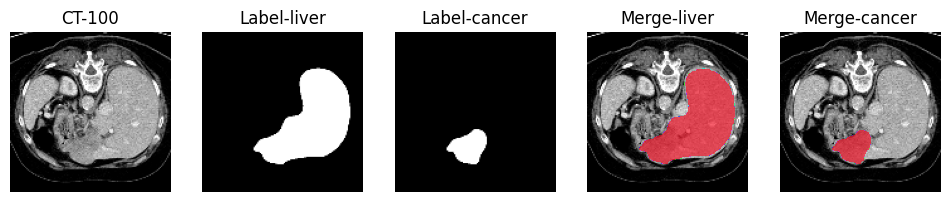

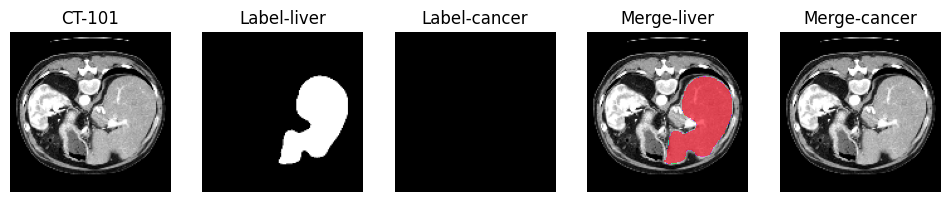

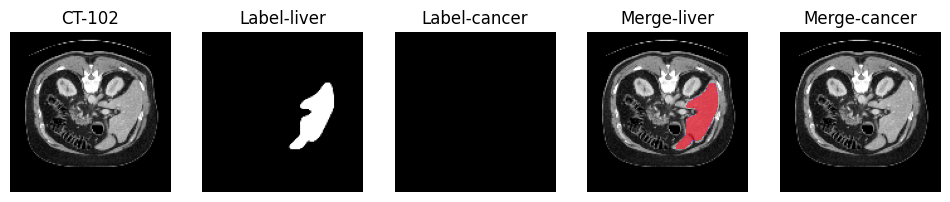

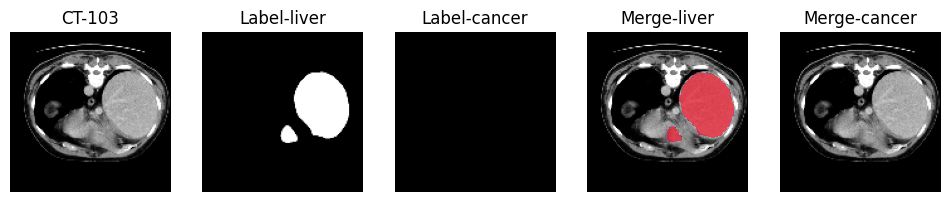

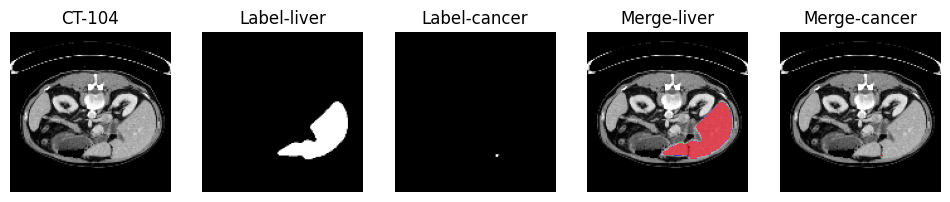

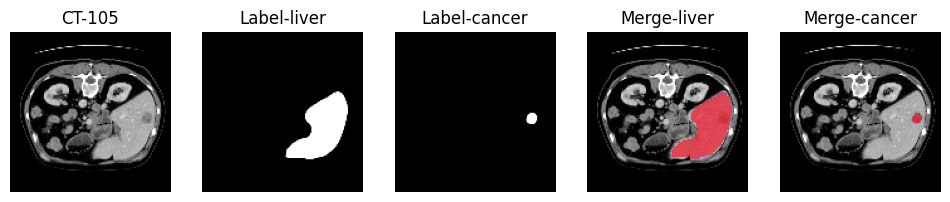

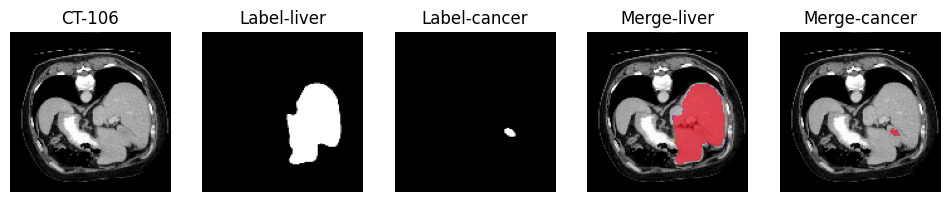

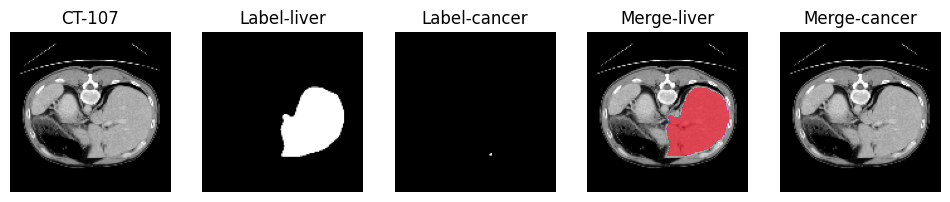

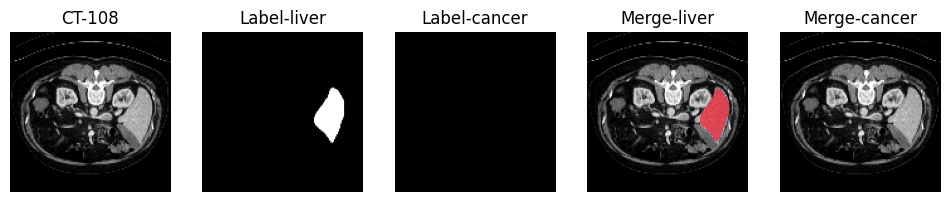

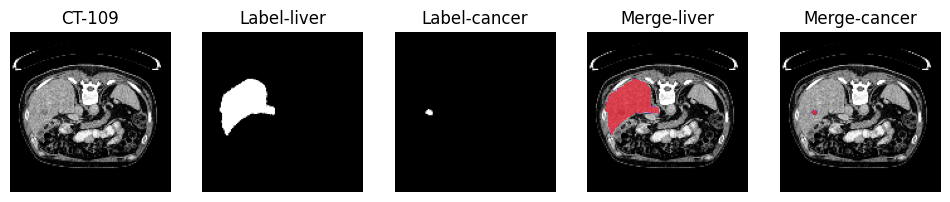

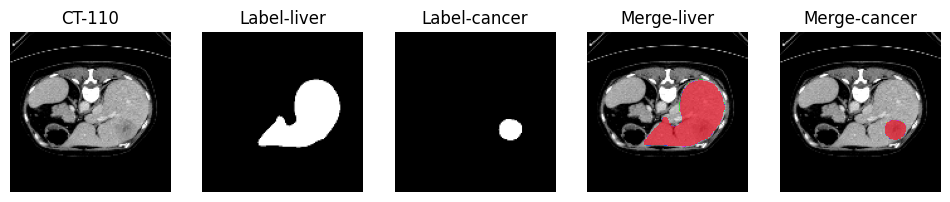

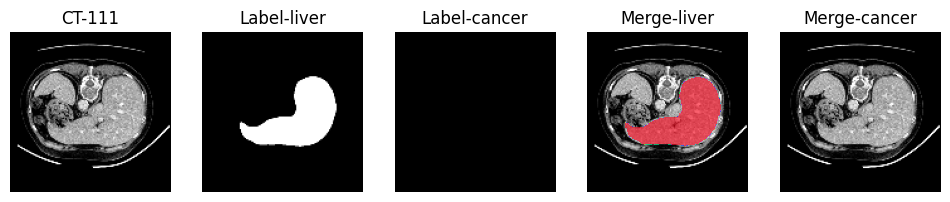

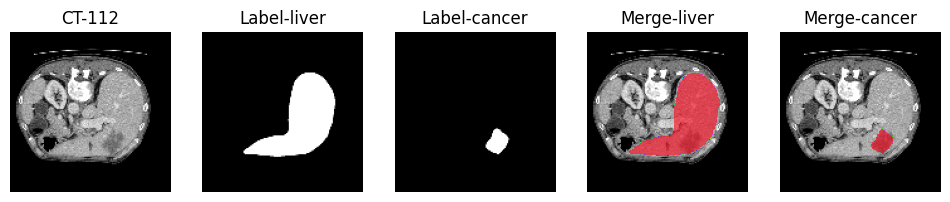

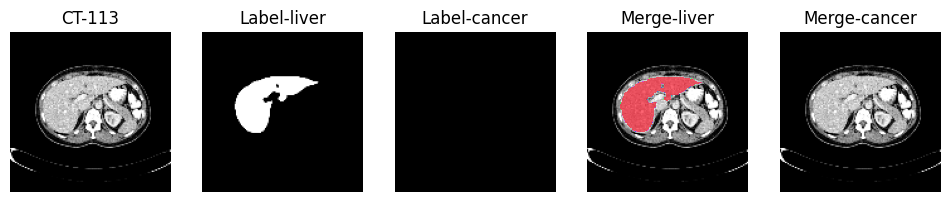

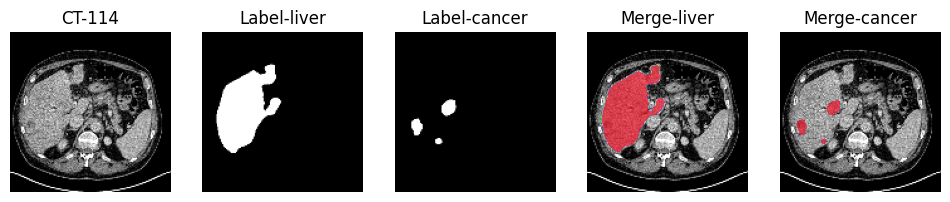

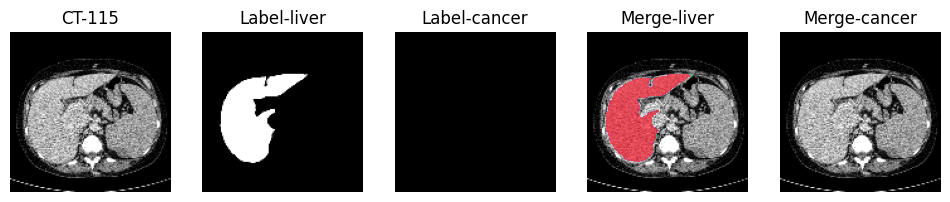

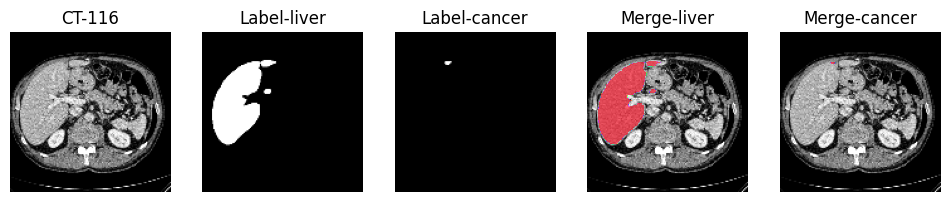

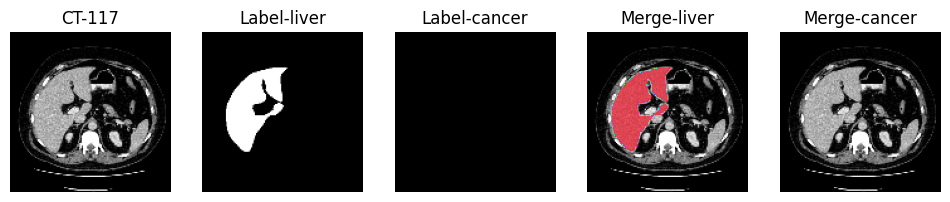

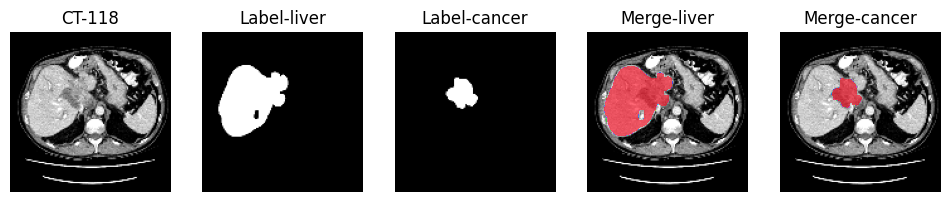

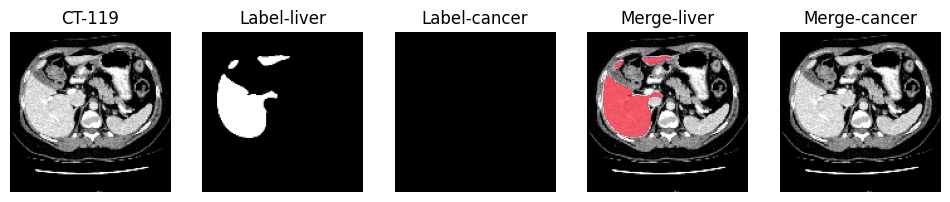

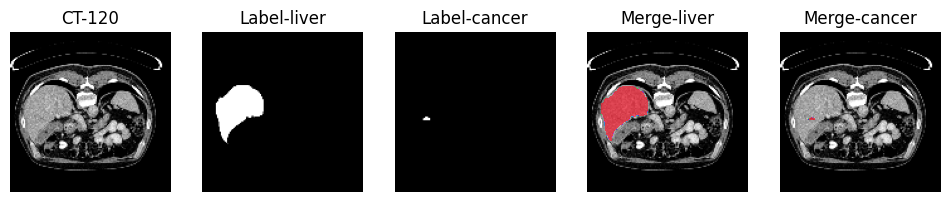

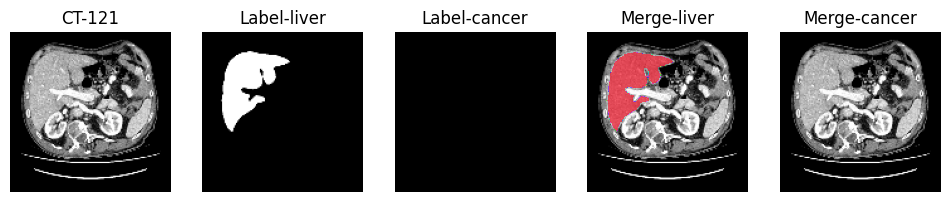

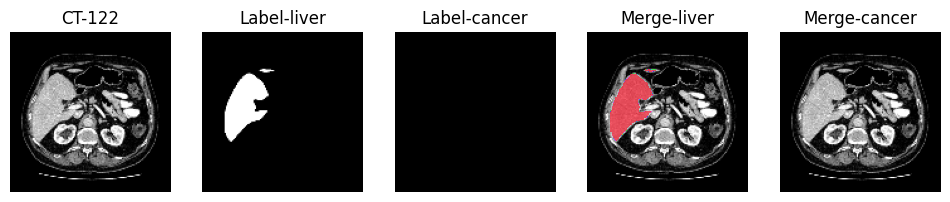

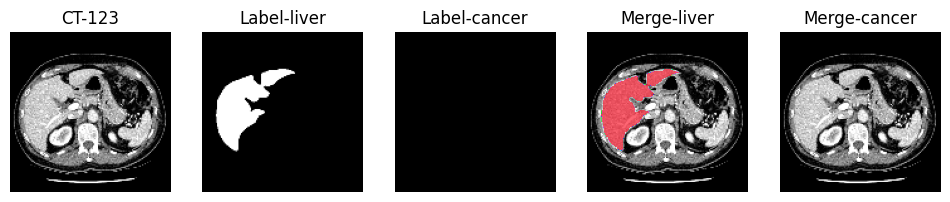

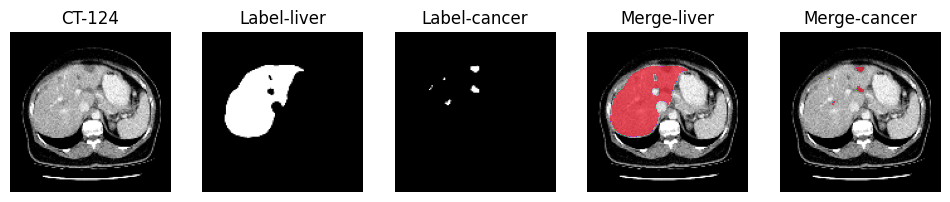

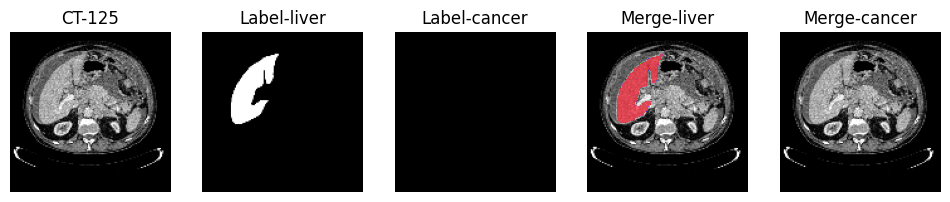

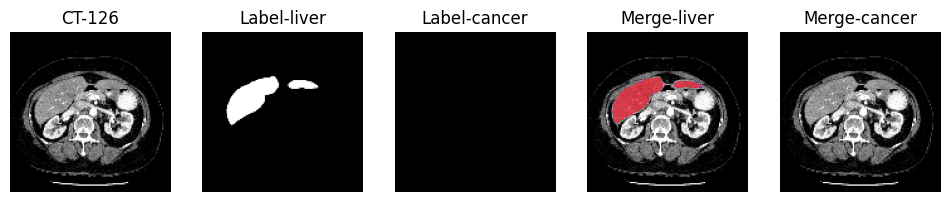

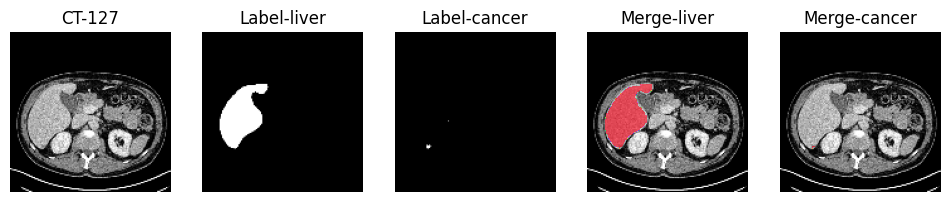

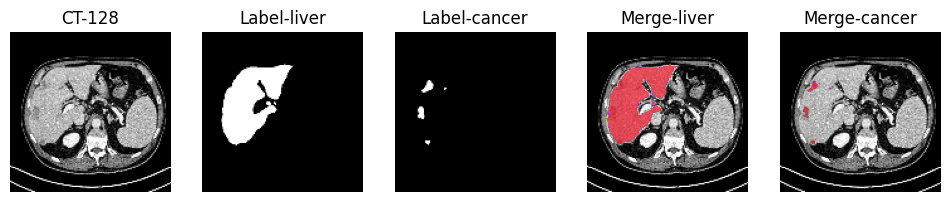

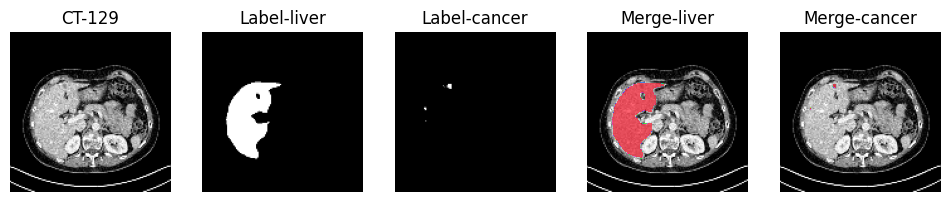

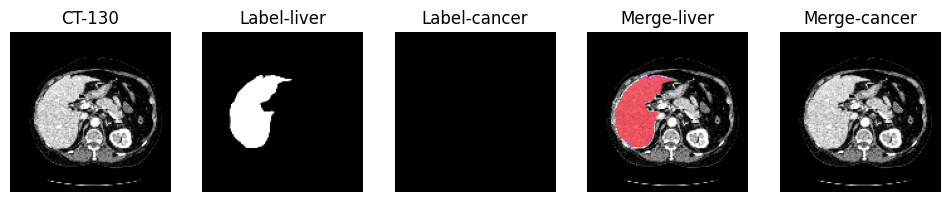

In [13]:
for i in range(0, len(re_ct__data)):
    image = re_ct__data[i,:,:,0]
    labe1 = re_lab_data[i,:,:,0]
    labe2 = re_lab_data[i,:,:,1]
    
    fig = plt.figure(figsize=(12, 12))
    
    ax1 = fig.add_subplot(2,5,1)
    ax1.imshow(image,cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'CT-{i}')
    
    ax2 = fig.add_subplot(2,5,2)
    ax2.imshow(labe1,cmap='gray')
    ax2.axis('off')
    ax2.set_title('Label-liver')
        
    ax3 = fig.add_subplot(2,5,3)
    ax3.imshow(labe2,cmap='gray')
    ax3.axis('off')
    ax3.set_title('Label-cancer')
    
    ax4 = fig.add_subplot(2,5,4)
    ax4.imshow(image,cmap='gray')
    tmpMask = labe1
    maskedRegion = np.ma.masked_where(tmpMask == 0, tmpMask)
    ax4.imshow(maskedRegion,cmap='hsv' ,alpha=0.6)
    ax4.axis('off')
    ax4.set_title('Merge-liver');
    
    ax5 = fig.add_subplot(2,5,5)
    ax5.imshow(image,cmap='gray')
    tmpMask = labe2
    maskedRegion = np.ma.masked_where(tmpMask == 0, tmpMask)
    ax5.imshow(maskedRegion,cmap='hsv' ,alpha=0.6)
    ax5.axis('off')
    ax5.set_title('Merge-cancer')

# save

In [14]:
ct_save_dir = f'{save_dir}/image'
liver_save_dir = f'{save_dir}/label/liver'
cancer_save_dir = f'{save_dir}/label/cancer'

print(save_dir)
print(ct_save_dir)
print(liver_save_dir)
print(cancer_save_dir)

os.makedirs(ct_save_dir, exist_ok=True)
os.makedirs(liver_save_dir, exist_ok=True)
os.makedirs(cancer_save_dir, exist_ok=True)

/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/0_data/data_preprocessing
/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/0_data/data_preprocessing/image
/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/0_data/data_preprocessing/label/liver
/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/0_data/data_preprocessing/label/cancer


In [16]:
for i in tqdm_notebook(range(len(re_ct__data))):
    file_name = os.path.basename(ct__list[i]).split('.')[0].split('-')[1]

    cv2.imwrite(f'{ct_save_dir}/{file_name}.png', re_ct__data[i,...,0])
    cv2.imwrite(f'{liver_save_dir}/{file_name}.png', re_lab_data[i,...,0])
    cv2.imwrite(f'{cancer_save_dir}/{file_name}.png', re_lab_data[i,...,1])
    

/tmp/ipykernel_1670335/2744618359.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(re_ct__data))):


  0%|          | 0/131 [00:00<?, ?it/s]